In [8]:
import networkx as nx
import niche
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
out_location = "paper_webs_0624"
import ATN
import multiprocessing
from multiprocessing import Pool
from os.path import exists

In [2]:
WEBS = 37
num_sims = [45,45,729] # per web in each category
label_strs = ["Intermediate Species Final Biomass","Top Species Final Biomass","% Change ES Amount", "Fraction Resident Species Remaining"]

In [6]:
# Generate final metrics for plotting and save

def get_intermediate_ids(net):
    int_species = []
    for node in net.nodes():
        
        #top predator would have no outgoing edges
        out_neighs = []
        out_neigh_list = list(net.out_edges([node]))
        for out_neigh in out_neigh_list:
            out_neighs.append(out_neigh[1])
            
        in_neighs = []
        in_neigh_list = list(net.in_edges([node]))
        for in_neigh in in_neigh_list: #curr_web.in_degree(node):
            in_neighs.append(in_neigh[0])
            
        if len(out_neighs) > 0 and len(in_neighs) > 0:
            int_species.append(node)
            
    return int_species

def get_basal_ids(net):
    basal_species = []
    
    for node in net.nodes():
        
        out_neighs = []
        out_neigh_list = list(net.out_edges([node]))
        for out_neigh in out_neigh_list:
            out_neighs.append(out_neigh[1])
            
        in_neighs = []
        in_neigh_list = list(net.in_edges([node]))
        for in_neigh in in_neigh_list: #curr_web.in_degree(node):
            in_neighs.append(in_neigh[0])
            
        if len(out_neighs) > 0 and len(in_neighs) == 0:
            basal_species.append(node)
            
    return basal_species
    
    
# four metrics of interest returned:
# intro_metric1 - final biomass of introduced species 1
# intro_metric2 - final biomass of introduced species 2
# es_metric - % change in es amount
# bio_metric - fraction resident species remaining
def get_metrics(web_init, web_final, b_init,b_final,inv_id1,inv_id2,es_fn):
        
    #based off of aggregate of intermediate species biomasses
    #init_int = get_intermediate_ids(web_init)
    init_int = get_basal_ids(web_init)
    b_total_init = 0
    for node in init_int:
        b_total_init += b_init[node]
    
    initial_es = es_fn(b_total_init)
    initial_bio = len(b_init.keys())
    
    inv_adj = 0
    intro_metric1 = 0
    intro_metric2 = 0
    if inv_id1 and inv_id1 in b_final:
        intro_metric1 = b_final[inv_id1]
        inv_adj = inv_adj - 1
    if inv_id2 and inv_id2 in b_final:
        intro_metric2 = b_final[inv_id2]
        inv_adj = inv_adj - 1
    
    #final_int = get_intermediate_ids(web_final)
    final_int = get_basal_ids(web_final)
    b_total_final = 0
    for node in final_int:
        if node != inv_id1 and node != inv_id2:
            b_total_final += b_final[node]
    
    final_es = es_fn(b_total_final)
    final_bio = len(b_final.keys()) + inv_adj # subtract out the invader counts
    
    es_metric = (final_es - initial_es)/initial_es*100
    bio_metric = final_bio/initial_bio
    
    return intro_metric1, intro_metric2, es_metric, bio_metric
    
# get es metric assuming it's provided by one species
def get_es_spec(b_init, b_final, es_spec):
    
    initial_es = es_linear(b_init[es_spec])
    
    if es_spec in b_final:
        final_es = es_linear(b_final[es_spec])
    else:
        final_es = 0    
    
    es_metric = (final_es - initial_es)/initial_es*100
    
    return es_metric
    
#maps the value of species biomass to es value
def es_linear(b_val):
    return b_val*0.5


In [7]:
# Generate final metrics for plotting and save to file 

fif_webs_file = open('./' + out_location + '/over15_webs.txt','r')

# ni, trophic level, num trophic levels, in-degree, out-degree, intro1_inv, intro2_inv, es_inv, bio_inv
inv1_simets = np.zeros((WEBS*num_sims[0],9))
inv2_simets = np.zeros((WEBS*num_sims[1],9))
inv1b_simets = np.zeros((WEBS*num_sims[2],9))
inv2b_simets = np.zeros((WEBS*num_sims[2],9))
si1 = 0
si2 = 0
si1b = 0
si2b = 0

for row in fif_webs_file:
    i = int(row)

    #initial biomass vector for web (before introduction, after run to equilibrium)
    webi,_,_,_,b_init_web = niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_2000")

    # invader 1
    inv_1_info = open('./' + out_location + '/invader_1.csv','r')
    inv1_reader = csv.reader(inv_1_info)
    next(inv1_reader)
    #object for temporary saving
    es_nodes = {}
    inv_1_res_dict = {}
    for line in inv1_reader:
        inv_id = int(line[0])
        #invaded web
        webt,nis,_,_,_= niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/one/web_" + str(i) + \
                                             "_inv_" + str(inv_id))
        #invaded web with additional 2000 timesteps after invasion
        webf,_,_,_,b_final_1 = niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/one/web_" + str(i) + \
                                                     "_inv_" + str(inv_id) + "_2000")
        intro1_inv, intro2_inv, es_inv, bio_inv = get_metrics(webi,webf,b_init_web,b_final_1,inv_id,None,es_linear)

        wtl = -1
        tl = -1
        ntl = -1
        try:
            wtl = nx.trophic_levels(webt)
            tl = wtl[inv_id]
            ntl = np.max(list(wtl.values()))
        except:
            print("trophic level calculation not possible for -- web: " + str(i) + " invader: " + str(inv_id))
        indeg = webt.in_degree(inv_id)
        outdeg = webt.out_degree(inv_id)
        inv1_simets[si1,:] = [nis[inv_id],tl,ntl,indeg,outdeg,intro1_inv, intro2_inv, es_inv, bio_inv]
        si1 +=1
        
    inv_1_info.close()

    # invader 2
    inv_2_info = open('./' + out_location + '/invader_2.csv','r')
    inv2_reader = csv.reader(inv_2_info)
    next(inv2_reader)
    #object for temporary saving
    inv_2_res_dict = {}
    es_nodes = {}
    for line in inv2_reader:
        inv_id = int(line[0])
        #invaded web
        webt,nis,_,_,_= niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/two/web_" + str(i) + \
                                             "_inv_" + str(inv_id))
        #invaded web with additional 2000 timesteps after invasion
        webf,_,_,_,b_final_2 = niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/two/web_" + str(i) + \
                                                     "_inv_" + str(inv_id) + "_2000")
        intro1_inv, intro2_inv, es_inv, bio_inv = get_metrics(webi,webf,b_init_web,b_final_2,None,inv_id,es_linear)

        wtl = -1
        tl = -1
        ntl = -1
        try:
            wtl = nx.trophic_levels(webt)
            tl = wtl[inv_id]
            ntl = np.max(list(wtl.values()))
        except:
            print("trophic level calculation not possible for -- web: " + str(i) + " invader: " + str(inv_id))
        indeg = webt.in_degree(inv_id)
        outdeg = webt.out_degree(inv_id)
        inv2_simets[si2,:] = [nis[inv_id],tl,ntl,indeg,outdeg,intro1_inv, intro2_inv, es_inv, bio_inv]
        si2 +=1

    inv_2_info.close()

    # both invaders 
    inv_both_info = open('./' + out_location + '/invader_both.csv','r')
    inv_both_reader = csv.reader(inv_both_info)
    next(inv_both_reader)
    #object for temporary saving
    inv_both_res_dict = {}
    es_nodes = {}
    for line in inv_both_reader:
        inv1_id = int(line[0])
        inv2_id = int(line[1])
        #invaded web
        webt,nis,_,_,_ = niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/both/web_" + str(i) + "_inv_" + str(inv1_id) + '_' + str(inv2_id))
        #invaded web with additional 2000 timesteps after invasion
        webf,_,_,_,b_final_b = niche.read_web_from_file("./" + out_location + "/web_" + str(i) + "_inv/both/web_" + str(i) + "_inv_" + str(inv1_id) + '_' + str(inv2_id) + "_2000")
        intro1_inv, intro2_inv, es_inv, bio_inv = get_metrics(webi,webf,b_init_web,b_final_b,inv1_id,inv2_id,es_linear)

        wtl = -1
        tl = -1
        ntl = -1
        try:
            wtl = nx.trophic_levels(webt)
            tl = wtl[inv2_id]
            ntl = np.max(list(wtl.values()))
        except:
            print("trophic level calculation not possible for -- web: " + str(i) + " invaders: " + str(inv1_id) +" "+ str(inv2_id))
        indeg = webt.in_degree(inv2_id)
        outdeg = webt.out_degree(inv2_id)
        inv2b_simets[si2b,:] = [nis[inv2_id],tl,ntl,indeg,outdeg,intro1_inv, intro2_inv, es_inv, bio_inv]
        si2b +=1

        wtl = -1
        tl = -1
        ntl = -1
        try:
            wtl = nx.trophic_levels(webt)
            tl = wtl[inv1_id]
            ntl = np.max(list(wtl.values()))
        except:
            print("trophic level calculation not possible for -- web: " + str(i) + " invaders: " + str(inv1_id) +" "+ str(inv2_id))
        indeg = webt.in_degree(inv1_id)
        outdeg = webt.out_degree(inv1_id)
        inv1b_simets[si1b,:] = [nis[inv1_id],tl,ntl,indeg,outdeg,intro1_inv, intro2_inv, es_inv, bio_inv]
        si1b +=1

    inv_both_info.close()

fif_webs_file.close()

trophic level calculation not possible for -- web: 8 invader: 337
trophic level calculation not possible for -- web: 8 invader: 343
trophic level calculation not possible for -- web: 8 invader: 349
trophic level calculation not possible for -- web: 8 invader: 355
trophic level calculation not possible for -- web: 8 invaders: 337 334
trophic level calculation not possible for -- web: 8 invaders: 337 334
trophic level calculation not possible for -- web: 8 invaders: 337 336
trophic level calculation not possible for -- web: 8 invaders: 337 336
trophic level calculation not possible for -- web: 8 invaders: 337 338
trophic level calculation not possible for -- web: 8 invaders: 337 338
trophic level calculation not possible for -- web: 8 invaders: 337 340
trophic level calculation not possible for -- web: 8 invaders: 337 340
trophic level calculation not possible for -- web: 8 invaders: 337 342
trophic level calculation not possible for -- web: 8 invaders: 337 342
trophic level calculation 

trophic level calculation not possible for -- web: 8 invaders: 349 408
trophic level calculation not possible for -- web: 8 invaders: 349 408
trophic level calculation not possible for -- web: 8 invaders: 349 410
trophic level calculation not possible for -- web: 8 invaders: 349 410
trophic level calculation not possible for -- web: 8 invaders: 349 412
trophic level calculation not possible for -- web: 8 invaders: 349 412
trophic level calculation not possible for -- web: 8 invaders: 349 414
trophic level calculation not possible for -- web: 8 invaders: 349 414
trophic level calculation not possible for -- web: 8 invaders: 349 416
trophic level calculation not possible for -- web: 8 invaders: 349 416
trophic level calculation not possible for -- web: 8 invaders: 349 418
trophic level calculation not possible for -- web: 8 invaders: 349 418
trophic level calculation not possible for -- web: 8 invaders: 349 420
trophic level calculation not possible for -- web: 8 invaders: 349 420
trophi

trophic level calculation not possible for -- web: 59 invaders: 337 414
trophic level calculation not possible for -- web: 59 invaders: 337 414
trophic level calculation not possible for -- web: 59 invaders: 337 416
trophic level calculation not possible for -- web: 59 invaders: 337 416
trophic level calculation not possible for -- web: 59 invaders: 337 418
trophic level calculation not possible for -- web: 59 invaders: 337 418
trophic level calculation not possible for -- web: 59 invaders: 337 420
trophic level calculation not possible for -- web: 59 invaders: 337 420
trophic level calculation not possible for -- web: 59 invaders: 337 422
trophic level calculation not possible for -- web: 59 invaders: 337 422
trophic level calculation not possible for -- web: 59 invaders: 343 334
trophic level calculation not possible for -- web: 59 invaders: 343 334
trophic level calculation not possible for -- web: 59 invaders: 343 336
trophic level calculation not possible for -- web: 59 invaders: 

trophic level calculation not possible for -- web: 65 invader: 410
trophic level calculation not possible for -- web: 65 invaders: 333 410
trophic level calculation not possible for -- web: 65 invaders: 333 410
trophic level calculation not possible for -- web: 65 invaders: 335 410
trophic level calculation not possible for -- web: 65 invaders: 335 410
trophic level calculation not possible for -- web: 65 invaders: 337 410
trophic level calculation not possible for -- web: 65 invaders: 337 410
trophic level calculation not possible for -- web: 65 invaders: 339 410
trophic level calculation not possible for -- web: 65 invaders: 339 410
trophic level calculation not possible for -- web: 65 invaders: 341 410
trophic level calculation not possible for -- web: 65 invaders: 341 410
trophic level calculation not possible for -- web: 65 invaders: 343 410
trophic level calculation not possible for -- web: 65 invaders: 343 410
trophic level calculation not possible for -- web: 65 invaders: 345 4

trophic level calculation not possible for -- web: 74 invaders: 337 348
trophic level calculation not possible for -- web: 74 invaders: 337 348
trophic level calculation not possible for -- web: 74 invaders: 337 350
trophic level calculation not possible for -- web: 74 invaders: 337 350
trophic level calculation not possible for -- web: 74 invaders: 337 370
trophic level calculation not possible for -- web: 74 invaders: 337 370
trophic level calculation not possible for -- web: 74 invaders: 337 372
trophic level calculation not possible for -- web: 74 invaders: 337 372
trophic level calculation not possible for -- web: 74 invaders: 337 374
trophic level calculation not possible for -- web: 74 invaders: 337 374
trophic level calculation not possible for -- web: 74 invaders: 337 376
trophic level calculation not possible for -- web: 74 invaders: 337 376
trophic level calculation not possible for -- web: 74 invaders: 337 378
trophic level calculation not possible for -- web: 74 invaders: 

1665
1665
number removed - 13
number removed - 1
number removed - 13
mean trophic level invader 1 (alone) - 2.9883794139377704
number removed - 1
mean trophic level invader 2 (alone) - 3.4571717290065367
number removed - 13
number removed - 1
number removed - 13
number removed - 13
number removed - 1
number removed - 1


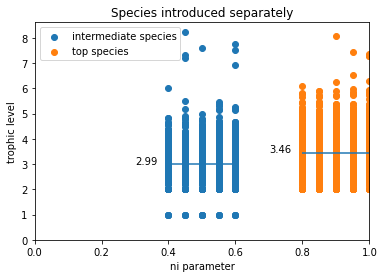

26973
26973
number removed - 270
number removed - 270
number removed - 270
mean trophic level invader 1 (together) - 2.9829055309826797
number removed - 270
mean trophic level invader 2 (together) - 3.5501639754165595
number removed - 270
number removed - 270
number removed - 270
number removed - 270
number removed - 270
number removed - 270


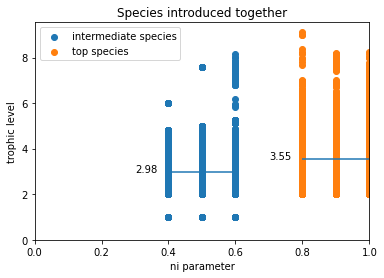

In [19]:
# TROPHIC LEVEL PLOTS - SI Figure 10

def remove_inds(listr, none_inds):
    newlist = []
    size1 = len(list(listr))
    for i in range(0,size1):
        if not (i in none_inds):
            newlist.append(listr[i])
    return newlist

def remove_nones1(listy):
    #remove cases where calculation didn't work (-1) !! And count the number to note.
    size1 = len(list(listy))
    none_inds = list(np.where(listy < 0)[0])
    newlist = remove_inds(listy,none_inds)
    size2 = len(newlist)
    print("number removed - " + str(size1-size2))
    return np.array(newlist), none_inds

def remove_nones2(list1,list2):
    newlist2,ind_to_rem = remove_nones1(list2)
    newlist1 = remove_inds(list1,ind_to_rem)
    return newlist1,newlist2

def scatter_remove_nones(list1,list2,lbl):
    list1, list2 = remove_nones2(list1,list2)
    plt.scatter(list(list1),list(list2),label=lbl)

print(len(inv1_simets[:,0]))
print(len(inv2_simets[:,0]))
scatter_remove_nones(inv1_simets[:,0],inv1_simets[:,1],"intermediate species")
scatter_remove_nones(inv2_simets[:,0],inv2_simets[:,1],"top species")
print("mean trophic level invader 1 (alone) - " + str(np.mean(remove_nones1(inv1_simets[:,1])[0])))
print("mean trophic level invader 2 (alone) - " + str(np.mean(remove_nones1(inv2_simets[:,1])[0])))
plt.xlim([0,1])
plt.hlines([np.mean(remove_nones1(inv1_simets[:,1])[0]),np.mean(remove_nones1(inv2_simets[:,1])[0])],[0.4,0.8],[0.6,1.0])
plt.text(0.3,np.mean(remove_nones1(inv1_simets[:,1])[0]),str(round(np.mean(remove_nones1(inv1_simets[:,1])[0]),2)))
plt.text(0.7,np.mean(remove_nones1(inv2_simets[:,1])[0]),str(round(np.mean(remove_nones1(inv2_simets[:,1])[0]),2)))
plt.gca().set_ylim(bottom=0)
plt.ylabel("trophic level")
plt.xlabel("ni parameter")
plt.title("Species introduced separately")
plt.legend()
plt.show()

print(len(inv1b_simets[:,0]))
print(len(inv2b_simets[:,0]))
scatter_remove_nones(inv1b_simets[:,0],inv1b_simets[:,1],"intermediate species")
scatter_remove_nones(inv2b_simets[:,0],inv2b_simets[:,1],"top species")
print("mean trophic level invader 1 (together) - " + str(np.mean(remove_nones1(inv1b_simets[:,1])[0])))
print("mean trophic level invader 2 (together) - " + str(np.mean(remove_nones1(inv2b_simets[:,1])[0])))
plt.xlim([0,1])
plt.ylabel("trophic level")
plt.xlabel("ni parameter")
plt.hlines([np.mean(remove_nones1(inv1b_simets[:,1])[0]),np.mean(remove_nones1(inv2b_simets[:,1])[0])],[0.4,0.8],[0.6,1.0])
plt.text(0.3,np.mean(remove_nones1(inv1b_simets[:,1])[0]),str(round(np.mean(remove_nones1(inv1b_simets[:,1])[0]),2)))
plt.text(0.7,np.mean(remove_nones1(inv2b_simets[:,1])[0]),str(round(np.mean(remove_nones1(inv2b_simets[:,1])[0]),2)))
plt.title("Species introduced together")
plt.gca().set_ylim(bottom=0)
plt.legend()
plt.show()

mean in degree invader 1 (alone) - 4.75975975975976
mean in degree invader 2 (alone) - 7.743543543543543


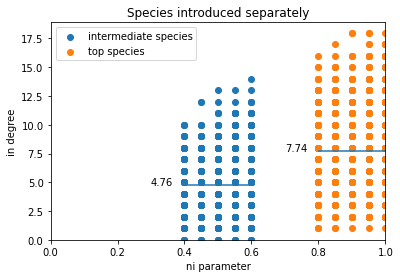

mean in degree invader 1 (alone) - 4.771104437771104
mean in degree invader 2 (alone) - 8.164497831164498


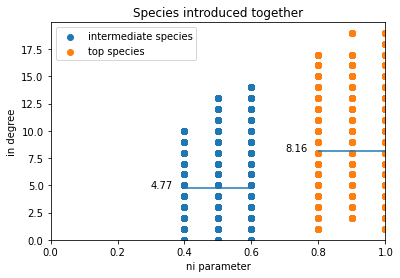

mean out degree invader 1 (alone) - 4.466066066066066
mean out degree invader 2 (alone) - 2.093093093093093


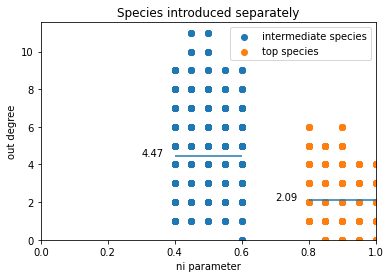

mean out degree invader 1 (alone) - 4.883216549883216
mean out degree invader 2 (alone) - 2.132465799132466


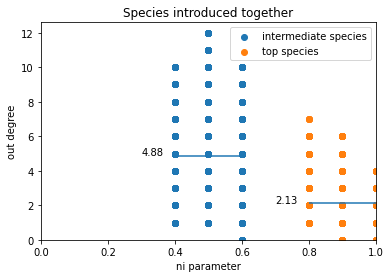

In [8]:
# IN AND OUT DEGREE PLOTS - SI Figure 10

def in_or_out_plot(m,metric):
    plt.scatter(list(inv1_simets[:,0]),list(inv1_simets[:,m]),label="intermediate species")
    plt.scatter(list(inv2_simets[:,0]),list(inv2_simets[:,m]),label="top species")
    print("mean " + metric + " invader 1 (alone) - " + str(np.mean(inv1_simets[:,m])))
    print("mean " + metric + " invader 2 (alone) - " + str(np.mean(inv2_simets[:,m])))
    plt.xlim([0,1])
    plt.hlines([np.mean(inv1_simets[:,m]),np.mean(inv2_simets[:,m])],[0.4,0.8],[0.6,1.0])
    plt.text(0.3,np.mean(inv1_simets[:,m]),str(round(np.mean(inv1_simets[:,m]),2)))
    plt.text(0.7,np.mean(inv2_simets[:,m]),str(round(np.mean(inv2_simets[:,m]),2)))
    plt.gca().set_ylim(bottom=0)
    plt.ylabel(metric)
    plt.xlabel("ni parameter")
    plt.title("Species introduced separately")
    plt.legend()
    plt.show()
          
    plt.scatter(list(inv1b_simets[:,0]),list(inv1b_simets[:,m]),label="intermediate species")
    plt.scatter(list(inv2b_simets[:,0]),list(inv2b_simets[:,m]),label="top species")
    print("mean " + metric + " invader 1 (alone) - " + str(np.mean(inv1b_simets[:,m])))
    print("mean " + metric + " invader 2 (alone) - " + str(np.mean(inv2b_simets[:,m])))
    plt.xlim([0,1])
    plt.hlines([np.mean(inv1b_simets[:,m]),np.mean(inv2b_simets[:,m])],[0.4,0.8],[0.6,1.0])
    plt.text(0.3,np.mean(inv1b_simets[:,m]),str(round(np.mean(inv1b_simets[:,m]),2)))
    plt.text(0.7,np.mean(inv2b_simets[:,m]),str(round(np.mean(inv2b_simets[:,m]),2)))
    plt.gca().set_ylim(bottom=0)
    plt.ylabel(metric)
    plt.xlabel("ni parameter")
    plt.title("Species introduced together")
    plt.legend()
    plt.show()    

in_or_out_plot(3,"in degree")
in_or_out_plot(4,"out degree")

number removed - 0
number removed - 0


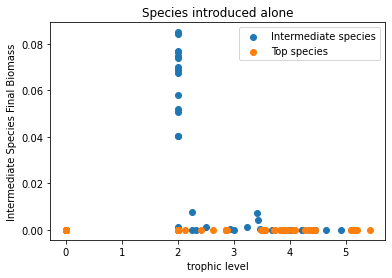

number removed - 0
number removed - 0


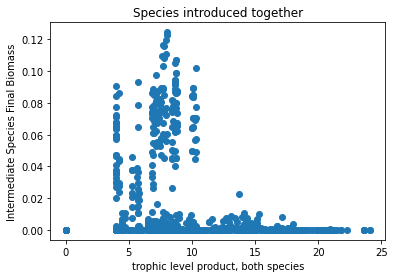

In [9]:
# REALIZED TROPHIC LEVELS VS OUTCOME METRICS
def tl_out(m,metric):
    list1, list2 = remove_nones2(inv1_simets[:,m],inv1_simets[:,1])
    plt.scatter(list(list2),list(list1),label="Intermediate species")
    list1, list2 = remove_nones2(inv2_simets[:,m],inv2_simets[:,1])
    plt.scatter(list(list2),list(list1),label="Top species")
    plt.title("Species introduced alone")
    plt.ylabel(metric)
    plt.xlabel("trophic level")
    plt.legend()
    plt.show()
    
    _, list2i = remove_nones2(inv1b_simets[:,m],inv1b_simets[:,1])
    list1, list2 = remove_nones2(inv2b_simets[:,m],inv2b_simets[:,1])
    plt.scatter(list(np.multiply(list2,list2i)),list(list1))
    plt.title("Species introduced together")
    plt.ylabel(metric)
    plt.xlabel("trophic level product, both species")
    plt.show()
      
tl_out(5,label_strs[0])

number removed - 13
number removed - 1


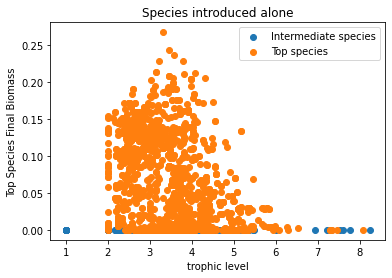

number removed - 270
number removed - 270


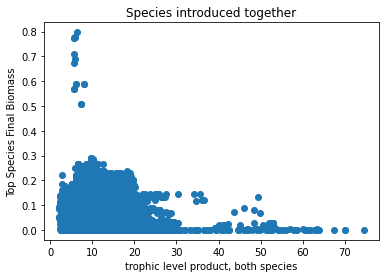

In [15]:
tl_out(6,label_strs[1])

number removed - 13
number removed - 1


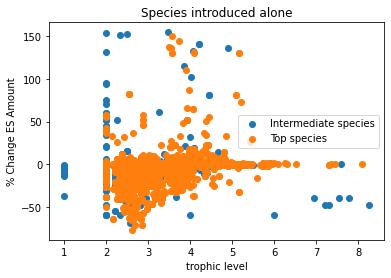

number removed - 270
number removed - 270


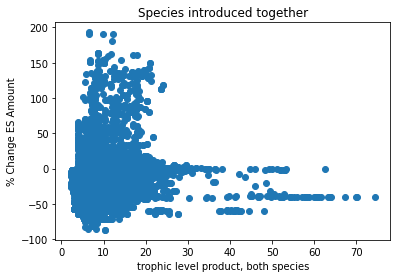

In [8]:
tl_out(7,label_strs[2])

number removed - 13
number removed - 1


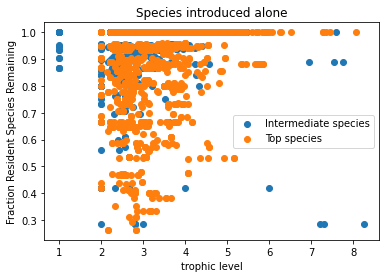

number removed - 270
number removed - 270


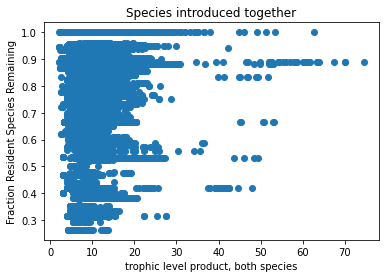

In [9]:
tl_out(8,label_strs[3])

In [10]:
# OUTCOME METRICS AND IN and OUT DEGREE 
# ni, trophic level, num trophic levels, in-degree, out-degree, intro1_inv, intro2_inv, es_inv, bio_inv

def deg_out(m,metric):
    plt.scatter(inv1_simets[:,3],inv1_simets[:,m],label="Intermediate species")
    plt.scatter(inv2_simets[:,3],inv2_simets[:,m],label="Top species")
    plt.title("Species introduced alone")
    plt.ylabel(metric)
    plt.xlabel("in degree")
    plt.legend()
    plt.show()
            
    plt.scatter(inv1_simets[:,4],inv1_simets[:,m],label="Intermediate species")
    plt.scatter(inv2_simets[:,4],inv2_simets[:,m],label="Top species")
    plt.title("Species introduced alone")
    plt.ylabel(metric)
    plt.xlabel("out degree")
    plt.legend()
    plt.show()

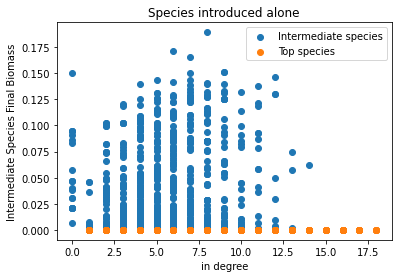

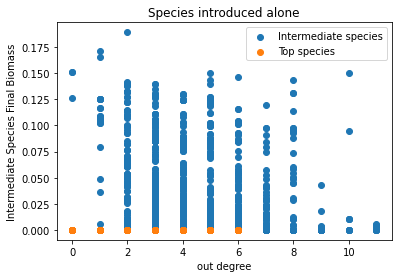

In [11]:
deg_out(5,label_strs[0])

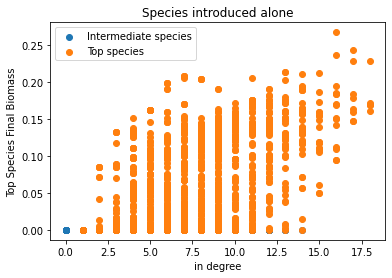

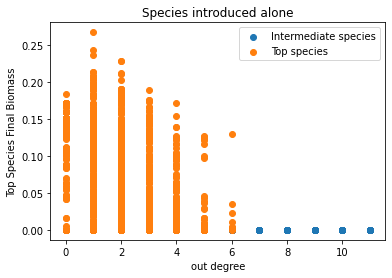

In [12]:
deg_out(6,label_strs[1])

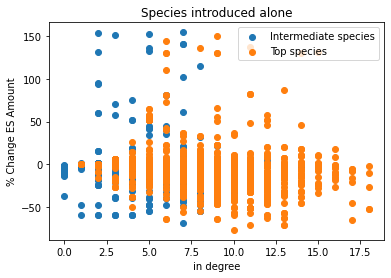

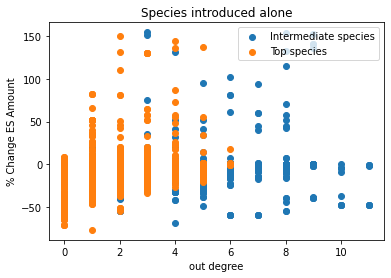

In [13]:
deg_out(7,label_strs[2])

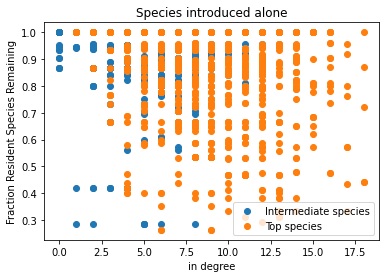

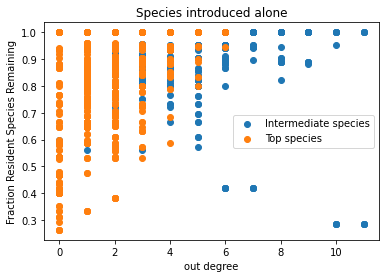

In [14]:
deg_out(8,label_strs[3])

In [10]:
#SHOW TIMESERIES FOR RUNNING THE INITIAL 37 WEBS TO EQUILIBRIUM

webs0 = []
final_webs_file = open('./' + out_location +  '/over15_webs.txt','r')
for row in final_webs_file:
    webs0.append(["./" + out_location + "/web_" + str(int(row)),2000,True])
    if not exists("./" + out_location + "/web_"+ str(int(row)) +"_edges.txt"):
        print("no " + "./" + out_location + "/web_"+ str(int(row))+ "_edges.txt")
    if not exists("./" + out_location + "/web_"+ str(int(row)) +"_nodes.txt"):
        print("no " + "./" + out_location + "/web_"+ str(int(row)) +"_nodes.txt")
    if not exists("./" + out_location + "/web_"+ str(int(row))+ "_details.csv"):
        print("no " + "./" + out_location + "/web_"+ str(int(row))+ "_details.csv")
final_webs_file.close()

[['./paper_webs_0624/web_0', 2000, True], ['./paper_webs_0624/web_4', 2000, True], ['./paper_webs_0624/web_8', 2000, True], ['./paper_webs_0624/web_10', 2000, True], ['./paper_webs_0624/web_13', 2000, True], ['./paper_webs_0624/web_14', 2000, True], ['./paper_webs_0624/web_16', 2000, True], ['./paper_webs_0624/web_18', 2000, True], ['./paper_webs_0624/web_19', 2000, True], ['./paper_webs_0624/web_24', 2000, True], ['./paper_webs_0624/web_25', 2000, True], ['./paper_webs_0624/web_28', 2000, True], ['./paper_webs_0624/web_34', 2000, True], ['./paper_webs_0624/web_35', 2000, True], ['./paper_webs_0624/web_36', 2000, True], ['./paper_webs_0624/web_39', 2000, True], ['./paper_webs_0624/web_40', 2000, True], ['./paper_webs_0624/web_41', 2000, True], ['./paper_webs_0624/web_43', 2000, True], ['./paper_webs_0624/web_47', 2000, True], ['./paper_webs_0624/web_48', 2000, True], ['./paper_webs_0624/web_49', 2000, True], ['./paper_webs_0624/web_50', 2000, True], ['./paper_webs_0624/web_55', 2000, T

without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_24 2000 timesteps...
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_35 2000 timesteps...
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_65 2000 timesteps...
without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_99 2000 timesteps...
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_28 2000 timesteps...
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
without the fix!
running dynamics for -- ./paper_webs_0624/web_47 2000 timesteps...
wit

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}
index dict: 
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15

/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Fij = (b_curr[index_dict[j]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarni

/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Fij = (b_curr[index_dict[j]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.py:69: RuntimeWarning: invalid value encountered in double_scalars
  Fji = (b_curr[index_dict[i]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.

/Users/luva6824/species_intro_modelling/ATN.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Fij = (b_curr[index_dict[j]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Fij = (b_curr[index_dict[j]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.

overall:


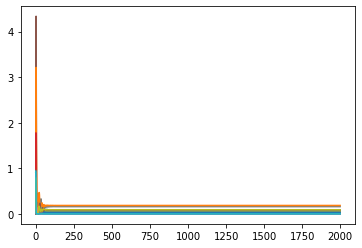

pruned node 0 with biomass 2.8510721479949697e-283
pruned node 1 with biomass 1.8783396633152226e-152
pruned node 3 with biomass 2.6018438544717316e-152
pruned node 6 with biomass 1.4792672417803488e-152
pruned node 8 with biomass 0.0
pruned node 12 with biomass 1.7284042966074536e-152
pruned node 13 with biomass 9.456585638932845e-28
pruned node 14 with biomass 2.8210481445585324e-30
pruned node 15 with biomass 5.447202290892513e-70
pruned node 17 with biomass 2.4253506911797484e-238
pruned node 22 with biomass 1.4875243375289992e-27
pruned node 24 with biomass 2.171097357111986e-238
./paper_webs_0624/web_36 final nodes: 18
final number of species after 2000 timesteps: 18
time for ./paper_webs_0624/web_36 591.7648704051971
overall:


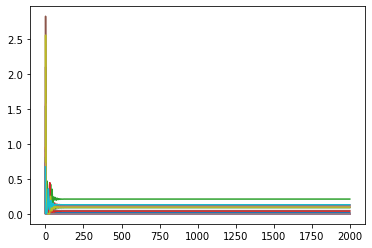

pruned node 0 with biomass 2.5e-323
pruned node 2 with biomass 2.5e-323
pruned node 4 with biomass 9.686608296935353e-142
pruned node 7 with biomass 2.5e-323
pruned node 9 with biomass 5.342193261961058e-297
pruned node 15 with biomass 4.6798543737443265e-22
pruned node 16 with biomass 2.5e-323
pruned node 18 with biomass 2.5e-323
pruned node 19 with biomass 1.334e-321
pruned node 20 with biomass 2.5e-323
pruned node 21 with biomass 2.5e-323
pruned node 24 with biomass 2.5e-323
pruned node 25 with biomass 8.536311129302718e-127
pruned node 26 with biomass 8.202375678998377e-282
pruned node 27 with biomass 5.483169404846393e-96
./paper_webs_0624/web_65 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_65 606.3197355270386
overall:


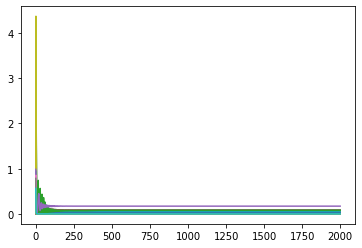

pruned node 5 with biomass 2.8363181215142916e-278
pruned node 8 with biomass 1.7207533237677181e-277
pruned node 9 with biomass 2.5840474066049674e-278
pruned node 13 with biomass 1.8780503175376615e-174
pruned node 14 with biomass 9.025580172693608e-281
pruned node 17 with biomass 3.221562146068542e-172
pruned node 21 with biomass 3.644765862298417e-278
pruned node 23 with biomass 1e-323
pruned node 26 with biomass 3.5e-323
pruned node 28 with biomass 6.809000583895399e-171
pruned node 29 with biomass 1.7707693073725053e-44
./paper_webs_0624/web_18 final nodes: 19
final number of species after 2000 timesteps: 19
time for ./paper_webs_0624/web_18 685.3165817260742
overall:


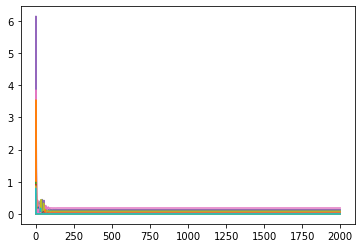

pruned node 0 with biomass 3.779666191157542e-179
pruned node 2 with biomass 1.749731041790795e-13
pruned node 3 with biomass 8.42553392911511e-232
pruned node 6 with biomass 1.9723281162260044e-20
pruned node 10 with biomass 1.2751001046448265e-256
pruned node 14 with biomass 1.601558086100102e-91
pruned node 15 with biomass 3.709378002859421e-232
pruned node 22 with biomass 1e-323
pruned node 23 with biomass 7.019316664939671e-31
pruned node 24 with biomass 2.5e-323
pruned node 27 with biomass 4.5410339418571124e-179
pruned node 28 with biomass 1e-323
pruned node 29 with biomass 1.9098603756279808e-258
./paper_webs_0624/web_76 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_76 724.6818673610687
overall:


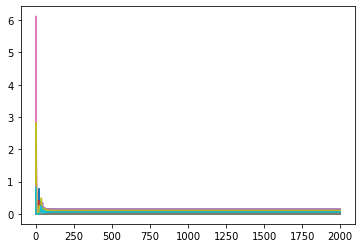

pruned node 6 with biomass 2.5e-323
pruned node 14 with biomass 3.619769800975447e-251
pruned node 19 with biomass 1.5591180824416289e-220
pruned node 21 with biomass 2.5e-323
pruned node 22 with biomass 2.5e-323
./paper_webs_0624/web_40 final nodes: 25
final number of species after 2000 timesteps: 25
time for ./paper_webs_0624/web_40 777.3948316574097
overall:


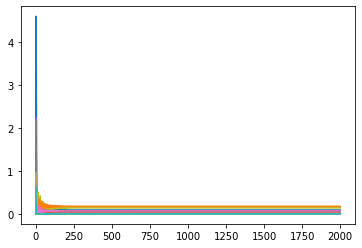

pruned node 1 with biomass 2.5e-323
pruned node 2 with biomass 4.46644041734848e-220
pruned node 6 with biomass 2.5e-323
pruned node 13 with biomass 1.4154741236318605e-219
pruned node 15 with biomass 2.3147200264601803e-244
pruned node 19 with biomass 2.5383510174712395e-219
pruned node 24 with biomass 1.7069906998747572e-220
pruned node 27 with biomass 2.641668118279884e-57
pruned node 28 with biomass 2.796204384177794e-57
pruned node 29 with biomass 5.857982957565062e-220
./paper_webs_0624/web_48 final nodes: 20
final number of species after 2000 timesteps: 20
time for ./paper_webs_0624/web_48 807.9861500263214
overall:


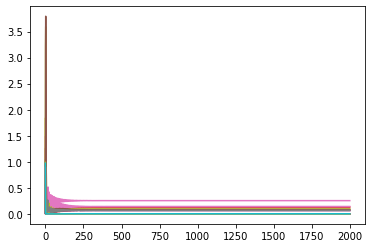

pruned node 0 with biomass 5.972532484325122e-49
pruned node 1 with biomass 3.144239088682871e-227
pruned node 2 with biomass 3e-323
pruned node 7 with biomass 7.734350564498943e-12
pruned node 8 with biomass 1.4362702497663527e-118
pruned node 9 with biomass 3e-323
pruned node 12 with biomass 3e-323
pruned node 15 with biomass 3e-323
pruned node 17 with biomass 1.0161163206210338e-44
pruned node 22 with biomass 3e-323
pruned node 20 with biomass 5.552340195777031e-222
pruned node 21 with biomass 1.8327127493159185e-12
pruned node 23 with biomass 3.777615834048017e-222
pruned node 26 with biomass 2.6756071036157853e-45
./paper_webs_0624/web_87 final nodes: 16
final number of species after 2000 timesteps: 16
time for ./paper_webs_0624/web_87 860.5046987533569
overall:


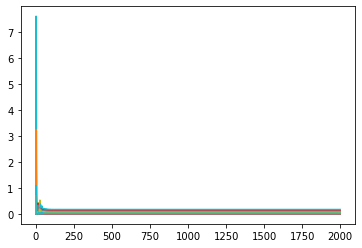

pruned node 1 with biomass 3e-323
pruned node 3 with biomass 2.5e-323
pruned node 6 with biomass 1.001401687127159e-235
pruned node 14 with biomass 3e-323
pruned node 20 with biomass 2.5e-323
pruned node 22 with biomass 2.5e-323
pruned node 25 with biomass 3.529599954117688e-154
./paper_webs_0624/web_77 final nodes: 23
final number of species after 2000 timesteps: 23
time for ./paper_webs_0624/web_77 894.7913115024567
overall:


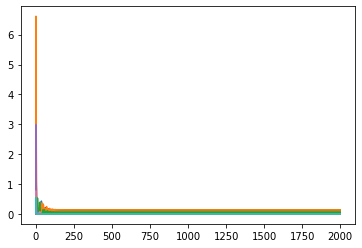

pruned node 1 with biomass 5.6243123375893814e-266
pruned node 4 with biomass 3e-323
pruned node 5 with biomass 3.440210234288161e-29
pruned node 6 with biomass 2.781160657026285e-29
pruned node 7 with biomass 2.070835070519429e-30
pruned node 16 with biomass 2.6794842554882342e-264
pruned node 17 with biomass 2.892321461233919e-230
pruned node 20 with biomass 3e-323
pruned node 23 with biomass 1.2532220577339517e-31
pruned node 24 with biomass 1.2739197966725671e-259
pruned node 25 with biomass 1.162483065490946e-224
pruned node 27 with biomass 5.424143802514603e-52
pruned node 29 with biomass 1.5726951584553232e-29
./paper_webs_0624/web_13 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_13 902.4122791290283
overall:


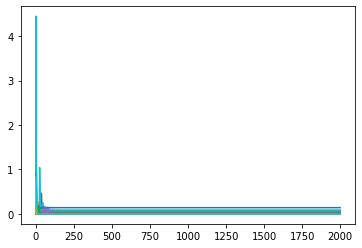

pruned node 0 with biomass 9.696218475647658e-127
pruned node 1 with biomass 3.5950496184414253e-109
pruned node 2 with biomass 2.5e-323
pruned node 6 with biomass 2.405881050225968e-109
pruned node 12 with biomass 1.5743659134062252e-283
pruned node 13 with biomass 2.5e-323
pruned node 14 with biomass 4.6298552834426624e-46
pruned node 17 with biomass 1.188277679231077e-170
pruned node 18 with biomass 1.4591454468961918e-187
pruned node 21 with biomass 2.5e-323
pruned node 23 with biomass 2.5e-323
pruned node 26 with biomass 1.0747765672655853e-169
pruned node 27 with biomass 2.5e-323
pruned node 28 with biomass 2.5e-323
pruned node 29 with biomass 1.4381743763960463e-84
./paper_webs_0624/web_66 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_66 913.9938805103302
overall:


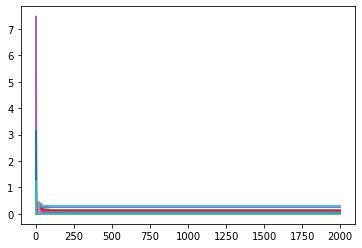

pruned node 0 with biomass 6.531952541971127e-229
pruned node 8 with biomass 1e-323
pruned node 11 with biomass 1e-323
pruned node 12 with biomass 1.0773203639760874e-142
pruned node 14 with biomass 9.672949505443583e-229
pruned node 16 with biomass 3.660441462789025e-143
pruned node 17 with biomass 3e-323
./paper_webs_0624/web_16 final nodes: 23
final number of species after 2000 timesteps: 23
time for ./paper_webs_0624/web_16 924.1377036571503
overall:


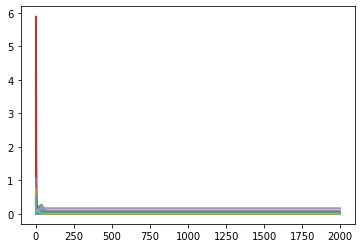

pruned node 3 with biomass 1.54814815816476e-33
pruned node 5 with biomass 3e-323
pruned node 7 with biomass 3e-323
pruned node 10 with biomass 5.994745736733769e-219
pruned node 12 with biomass 1.2551455385305113e-80
pruned node 16 with biomass 4.648402177087899e-81
pruned node 17 with biomass 3e-323
pruned node 20 with biomass 4.8102405805305225e-214
pruned node 22 with biomass 5.455710426955729e-213
pruned node 24 with biomass 1.2618576777936155e-64
pruned node 25 with biomass 3.819097585238694e-280
pruned node 27 with biomass 3e-323
./paper_webs_0624/web_24 final nodes: 18
final number of species after 2000 timesteps: 18
time for ./paper_webs_0624/web_24 937.3572330474854
overall:


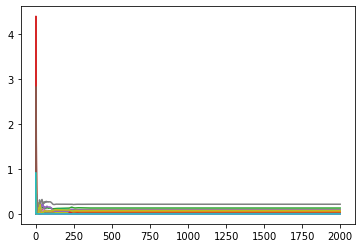

pruned node 0 with biomass 8.284201924402466e-77
pruned node 1 with biomass 4.180725972076856e-12
pruned node 4 with biomass 3e-323
pruned node 7 with biomass 2.5e-323
pruned node 8 with biomass 8.795292329869362e-150
pruned node 13 with biomass 8.865930365417019e-20
pruned node 16 with biomass 6.341460646081177e-11
pruned node 19 with biomass 3.1551688314955023e-96
pruned node 20 with biomass 2.5e-323
pruned node 22 with biomass 1.1570678803721421e-154
pruned node 25 with biomass 1.1638121560214773e-192
pruned node 26 with biomass 8.721945167718237e-14
pruned node 29 with biomass 1.480664359280073e-76
./paper_webs_0624/web_19 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_19 942.5077044963837
overall:


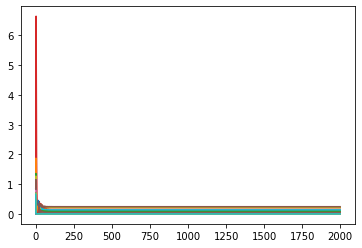

pruned node 2 with biomass 7.592536689006112e-172
pruned node 4 with biomass 4.19641791537065e-170
pruned node 5 with biomass 3.605025155283956e-121
pruned node 6 with biomass 1.1403742689213784e-19
pruned node 9 with biomass 7.080147463838721e-20
pruned node 11 with biomass 4.668725363917209e-139
pruned node 16 with biomass 8.324713935598314e-20
pruned node 17 with biomass 1.7712113166154576e-169
pruned node 18 with biomass 3e-323
pruned node 24 with biomass 3e-323
pruned node 26 with biomass 8.360534513326376e-110
pruned node 28 with biomass 3e-323
pruned node 29 with biomass 3e-323
./paper_webs_0624/web_55 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_55 963.5270700454712
overall:


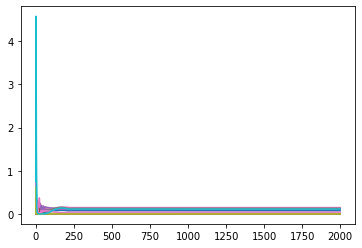

pruned node 0 with biomass 2.1323682376910447e-74
pruned node 7 with biomass 3e-323
pruned node 8 with biomass 3e-323
pruned node 11 with biomass 1.77821940541302e-309
pruned node 12 with biomass 3e-323
pruned node 13 with biomass 3e-323
pruned node 16 with biomass 3e-323
pruned node 18 with biomass 1.897490304611745e-73
pruned node 19 with biomass 3e-323
pruned node 20 with biomass 2.176390522594908e-73
pruned node 22 with biomass 3e-323
pruned node 23 with biomass 3.1568075027271223e-74
pruned node 24 with biomass 6.3002149861733e-310
pruned node 27 with biomass 3e-323
pruned node 28 with biomass 3e-323
./paper_webs_0624/web_93 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_93 967.1442587375641
overall:


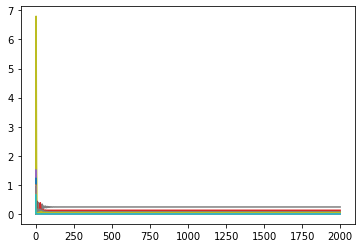

pruned node 1 with biomass 5.166423478340817e-182
pruned node 2 with biomass 3.0147021712233637e-305
pruned node 3 with biomass 3e-323
pruned node 4 with biomass 1.4807477252801258e-208
pruned node 7 with biomass 2.4569758419000346e-293
pruned node 9 with biomass 5.6363063756975986e-27
pruned node 11 with biomass 5.228924387470294e-22
pruned node 13 with biomass 4.2331389899193864e-58
pruned node 18 with biomass 2.5e-323
pruned node 19 with biomass 5.677535073707904e-60
pruned node 26 with biomass 1.8956873420816148e-95
pruned node 29 with biomass 5.831371197391501e-60
./paper_webs_0624/web_99 final nodes: 18
final number of species after 2000 timesteps: 18
time for ./paper_webs_0624/web_99 984.4562969207764
overall:


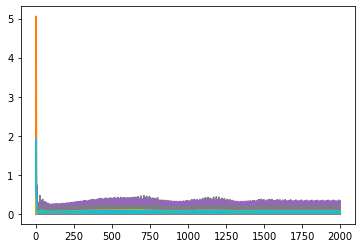

pruned node 0 with biomass 4.101448090761757e-35
pruned node 5 with biomass 3e-323
pruned node 8 with biomass 1.0690322378536482e-249
pruned node 9 with biomass 8.76389667476615e-251
pruned node 10 with biomass 3e-323
pruned node 16 with biomass 1.4370207785459232e-70
pruned node 20 with biomass 1.8833234021443108e-17
pruned node 23 with biomass 3e-323
pruned node 25 with biomass 1.5843137918552716e-298
overall:
pruned node 27 with biomass 1.5640820632467557e-30
./paper_webs_0624/web_47 final nodes: 20
final number of species after 2000 timesteps: 20
time for ./paper_webs_0624/web_47 1004.1199607849121


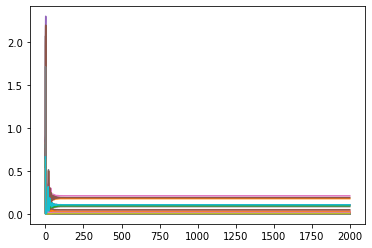

pruned node 2 with biomass 1.0230395007304793e-87
pruned node 5 with biomass 4.222759300543115e-89
pruned node 6 with biomass 1.5269368024315955e-79
pruned node 8 with biomass 3e-323
pruned node 10 with biomass 3e-323
pruned node 17 with biomass 1.8644517068468202e-71
pruned node 19 with biomass 3e-323
pruned node 20 with biomass 9.58742733988799e-97
pruned node 22 with biomass 3e-323
pruned node 24 with biomass 3e-323
pruned node 27 with biomass 7.23083156410663e-37
./paper_webs_0624/web_41 final nodes: 19
final number of species after 2000 timesteps: 19
time for ./paper_webs_0624/web_41 1005.0273127555847
overall:


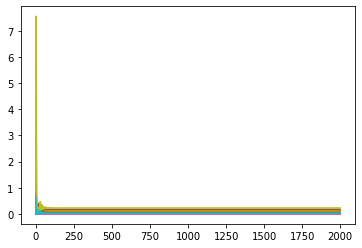

pruned node 5 with biomass 2.803562777555037e-54
pruned node 6 with biomass 4.229116585465564e-52
pruned node 7 with biomass 3e-323
pruned node 9 with biomass 2.4263579838046664e-84
pruned node 10 with biomass 1.2136341075596541e-297
pruned node 13 with biomass 4.055969642745095e-35
pruned node 14 with biomass 8.98248096372391e-26
pruned node 17 with biomass 9.602733435928091e-74
pruned node 20 with biomass 3e-323
pruned node 21 with biomass 3e-323
pruned node 24 with biomass 1.1335554322631431e-73
./paper_webs_0624/web_50 final nodes: 19
final number of species after 2000 timesteps: 19
time for ./paper_webs_0624/web_50 1009.2425491809845
overall:


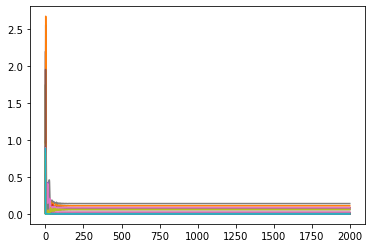

pruned node 1 with biomass 8.623098204550325e-167
pruned node 2 with biomass 4.179271673668667e-276
pruned node 8 with biomass 5.252797371706438e-167
pruned node 9 with biomass 1.3288668058387844e-257
pruned node 17 with biomass 3.336205810619452e-259
pruned node 19 with biomass 3e-323
pruned node 20 with biomass 1.0142728971741565e-164
pruned node 21 with biomass 1.1098440033330716e-169
pruned node 22 with biomass 3e-323
pruned node 24 with biomass 4.053376620372337e-169
pruned node 29 with biomass 1.1038518902073057e-166
./paper_webs_0624/web_35 final nodes: 19
final number of species after 2000 timesteps: 19
time for ./paper_webs_0624/web_35 1031.8536162376404
overall:


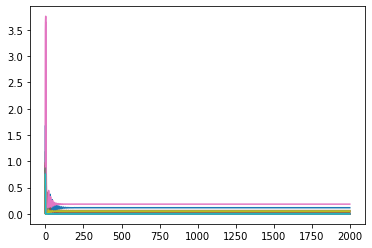

pruned node 0 with biomass 1.5021946407289233e-241
pruned node 1 with biomass 1.1309930119597991e-241
pruned node 2 with biomass 2.5006467902769e-241
pruned node 5 with biomass 5.335445323948011e-52
pruned node 9 with biomass 1.5596456516584588e-297
pruned node 11 with biomass 1.9291188068339501e-75
pruned node 12 with biomass 1.6687881779383406e-280
pruned node 14 with biomass 1.2736757915792654e-171
pruned node 19 with biomass 9.762769943251909e-173
pruned node 21 with biomass 1.0851702678185017e-241
pruned node 22 with biomass 4.412015199264055e-294
pruned node 23 with biomass 3e-323
./paper_webs_0624/web_28 final nodes: 18
final number of species after 2000 timesteps: 18
time for ./paper_webs_0624/web_28 1032.6122040748596
overall:


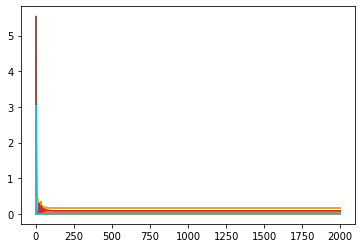

pruned node 0 with biomass 3e-323
pruned node 7 with biomass 2.802835011703278e-234
pruned node 9 with biomass 3e-323
pruned node 15 with biomass 3e-323
pruned node 16 with biomass 3e-323
pruned node 17 with biomass 3e-323
pruned node 19 with biomass 1.5964756862955624e-218
pruned node 22 with biomass 3e-323
pruned node 24 with biomass 3e-323
pruned node 28 with biomass 3e-323
./paper_webs_0624/web_69 final nodes: 20
final number of species after 2000 timesteps: 20
time for ./paper_webs_0624/web_69 1036.87441945076
overall:


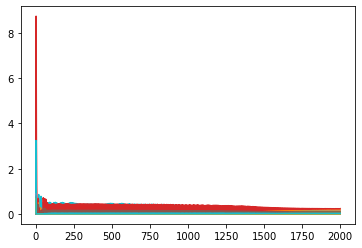

pruned node 0 with biomass 5.835093190445723e-30
pruned node 2 with biomass 3e-323
pruned node 3 with biomass 1.4818274723429848e-29
pruned node 5 with biomass 3e-323
pruned node 7 with biomass 3e-323
pruned node 8 with biomass 4.0588794718464834e-27
pruned node 10 with biomass 3e-323
pruned node 11 with biomass 1.0569137030858161e-129
pruned node 15 with biomass 2.681374183479854e-164
pruned node 17 with biomass 3e-323
pruned node 22 with biomass 1.7597924099234854e-165
pruned node 24 with biomass 2.1282248565160412e-29
pruned node 26 with biomass 3e-323
pruned node 27 with biomass 6.106457506759587e-22
./paper_webs_0624/web_75 final nodes: 16
final number of species after 2000 timesteps: 16
time for ./paper_webs_0624/web_75 1046.230052947998
overall:


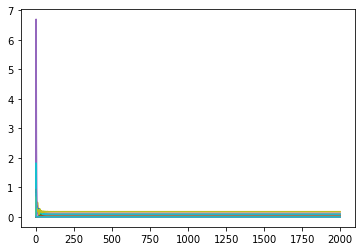

pruned node 0 with biomass 2.5e-323
pruned node 7 with biomass 1.357696958954782e-127
pruned node 11 with biomass 2.365639817442137e-128
pruned node 12 with biomass 6.199769120372462e-57
pruned node 18 with biomass 7.66616163299981e-219
pruned node 20 with biomass 2.4641559242043912e-55
pruned node 25 with biomass 1.0158716101986527e-276
pruned node 26 with biomass 2.4439551057412497e-127
pruned node 29 with biomass 2.8121308539634117e-195
./paper_webs_0624/web_14 final nodes: 21
final number of species after 2000 timesteps: 21
time for ./paper_webs_0624/web_14 1050.18913936615
overall:


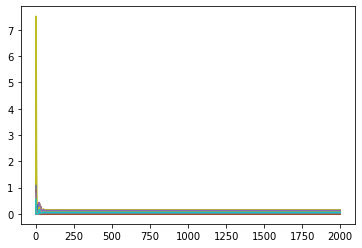

pruned node 3 with biomass 3e-323
pruned node 4 with biomass 2.5e-323
pruned node 5 with biomass 9.162298081683019e-163
pruned node 7 with biomass 9.933623360245657e-99
pruned node 9 with biomass 2.5e-323
pruned node 12 with biomass 1.0645609775250878e-208
pruned node 17 with biomass 9.840549015862627e-267
pruned node 19 with biomass 1.3057951447066762e-300
pruned node 21 with biomass 7.728696177677036e-192
pruned node 22 with biomass 3e-323
pruned node 23 with biomass 2.5e-323
./paper_webs_0624/web_57 final nodes: 19
final number of species after 2000 timesteps: 19
time for ./paper_webs_0624/web_57 1072.8762247562408
overall:


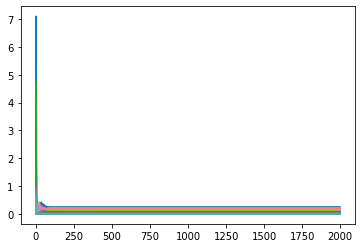

pruned node 6 with biomass 5.003547658987411e-134
pruned node 9 with biomass 2.1695331222542872e-91
pruned node 15 with biomass 3e-323
pruned node 16 with biomass 6.32554088834145e-95
pruned node 17 with biomass 3e-323
pruned node 19 with biomass 2.60835816235914e-290
pruned node 20 with biomass 1.0557492815914977e-252
pruned node 25 with biomass 1.320627773336781e-226
pruned node 29 with biomass 4.842335606070939e-134
./paper_webs_0624/web_25 final nodes: 21
final number of species after 2000 timesteps: 21
time for ./paper_webs_0624/web_25 1074.1100060939789
overall:


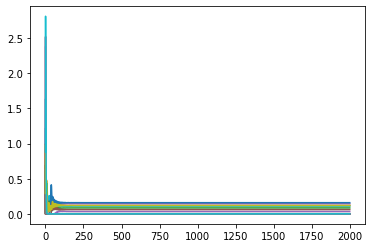

pruned node 0 with biomass 3.5e-323
pruned node 2 with biomass 3e-323
pruned node 3 with biomass 6.741545450860205e-70
pruned node 5 with biomass 3e-323
pruned node 8 with biomass 7.033239189387608e-77
pruned node 11 with biomass 7.38379232526712e-77
pruned node 13 with biomass 3e-323
pruned node 18 with biomass 1.6628394345496068e-38
pruned node 21 with biomass 3e-323
pruned node 22 with biomass 6.510509317219425e-75
pruned node 23 with biomass 3e-323
pruned node 24 with biomass 2.6550443693634842e-45
pruned node 27 with biomass 3e-323
./paper_webs_0624/web_34 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_34 1082.2601416110992
overall:


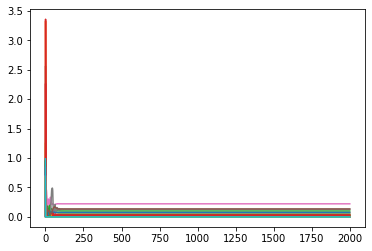

pruned node 0 with biomass 3e-323
pruned node 1 with biomass 3e-323
pruned node 4 with biomass 3e-323
pruned node 5 with biomass 3e-323
pruned node 6 with biomass 7.8771320725224e-14
pruned node 9 with biomass 1.9081663799950614e-193
pruned node 10 with biomass 3e-323
pruned node 14 with biomass 3e-323
pruned node 18 with biomass 7.896773589055871e-14
pruned node 19 with biomass 3e-323
pruned node 24 with biomass 7.893589554830132e-14
pruned node 26 with biomass 3e-323
pruned node 27 with biomass 6.91150796927716e-159
pruned node 28 with biomass 2.045523665776429e-198
pruned node 29 with biomass 3e-323
./paper_webs_0624/web_8 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_8 1083.8295340538025
overall:


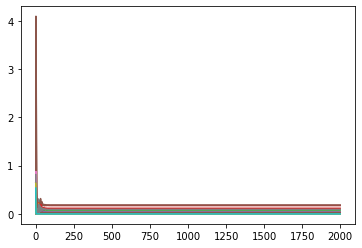

pruned node 0 with biomass 3.5e-323
pruned node 10 with biomass 3.5e-323
pruned node 11 with biomass 7.509127532349203e-276
pruned node 14 with biomass 4.3231042720872235e-244
pruned node 16 with biomass 9.521709456414505e-17
pruned node 18 with biomass 3e-323
pruned node 26 with biomass 1.2131427104479684e-244
pruned node 28 with biomass 3e-323
pruned node 29 with biomass 3e-323
./paper_webs_0624/web_10 final nodes: 21
final number of species after 2000 timesteps: 21
time for ./paper_webs_0624/web_10 1095.0372695922852
overall:


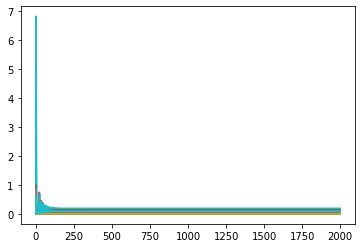

pruned node 0 with biomass 1.2632486560656234e-287
pruned node 5 with biomass 3e-323
pruned node 7 with biomass 9.855401580669655e-28
pruned node 8 with biomass 1.7087905381233532e-11
pruned node 9 with biomass 4.9751139894647075e-12
pruned node 11 with biomass 2.639089087996132e-287
pruned node 13 with biomass 1.3191967767786395e-123
pruned node 14 with biomass 3e-323
pruned node 15 with biomass 6.02754560511211e-268
pruned node 16 with biomass 3e-323
pruned node 18 with biomass 1.734520176809752e-287
pruned node 20 with biomass 6.168315657733697e-122
pruned node 22 with biomass 2.4711870537478246e-266
pruned node 25 with biomass 4.608277073164603e-12
pruned node 28 with biomass 4.6379321479439956e-12
./paper_webs_0624/web_4 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_4 1105.3760738372803
overall:


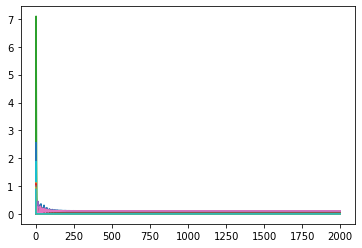

pruned node 0 with biomass 2.4964928657247776e-86
pruned node 1 with biomass 6.3109189626114374e-164
pruned node 3 with biomass 4.1682894830442866e-86
pruned node 4 with biomass 1.0148541543536875e-56
pruned node 5 with biomass 1.5553083498611596e-305
pruned node 7 with biomass 1.568357145616014e-86
pruned node 8 with biomass 1.2814050759961584e-57
pruned node 12 with biomass 5.655053541132246e-164
pruned node 13 with biomass 1e-323
pruned node 15 with biomass 3e-323
pruned node 16 with biomass 1e-323
pruned node 19 with biomass 2.7270463854928934e-113
pruned node 20 with biomass 1.5258328201499188e-56
pruned node 21 with biomass 3e-323
pruned node 29 with biomass 3e-323
./paper_webs_0624/web_49 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_49 1106.5114641189575
overall:


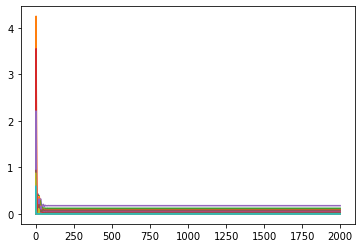

pruned node 0 with biomass 1.2696981802306249e-193
pruned node 1 with biomass 1.3557979646376513e-193
pruned node 5 with biomass 3e-323
pruned node 11 with biomass 3e-323
pruned node 13 with biomass 1.3122036107867185e-190
pruned node 18 with biomass 6.284795353035125e-188
pruned node 19 with biomass 2.580755198533184e-199
pruned node 22 with biomass 3e-323
pruned node 26 with biomass 3e-323
pruned node 29 with biomass 1.9987810806846761e-196
./paper_webs_0624/web_74 final nodes: 20
final number of species after 2000 timesteps: 20
time for ./paper_webs_0624/web_74 1110.2747130393982
overall:


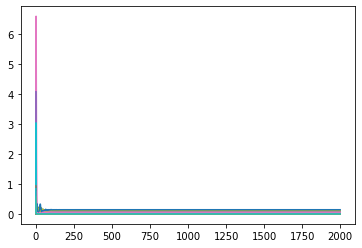

pruned node 0 with biomass 1.0362462424471864e-93
pruned node 11 with biomass 3e-323
pruned node 12 with biomass 3e-323
pruned node 13 with biomass 1.94511536552761e-91
pruned node 14 with biomass 6.098513245293238e-86
pruned node 15 with biomass 3e-323
pruned node 17 with biomass 1.13975648633627e-309
pruned node 21 with biomass 3.744e-320
pruned node 23 with biomass 3e-323
pruned node 25 with biomass 5.9507272579310494e-198
pruned node 27 with biomass 2.1315422632063893e-47
pruned node 28 with biomass 1.10914e-318
pruned node 29 with biomass 3e-323
./paper_webs_0624/web_43 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_43 1120.75244140625
overall:


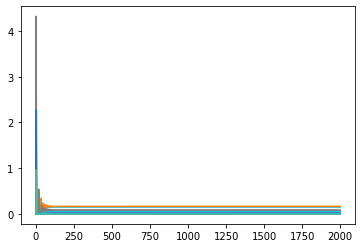

pruned node 3 with biomass 3.5e-323
pruned node 5 with biomass 3e-323
pruned node 8 with biomass 3.5e-323
pruned node 12 with biomass 3.1877501970254897e-273
pruned node 20 with biomass 3e-323
pruned node 23 with biomass 6.985927196954673e-273
pruned node 24 with biomass 1.5066506166436008e-272
pruned node 25 with biomass 3e-323
pruned node 26 with biomass 4.088510598497056e-273
./paper_webs_0624/web_0 final nodes: 21
final number of species after 2000 timesteps: 21
time for ./paper_webs_0624/web_0 1129.2085933685303
overall:


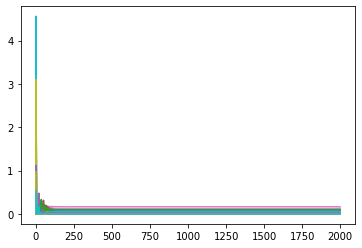

pruned node 0 with biomass 3e-323
pruned node 3 with biomass 1.9309878776278395e-138
pruned node 5 with biomass 2.0795544730663426e-293
pruned node 7 with biomass 3e-323
pruned node 8 with biomass 9.87205916290179e-67
pruned node 10 with biomass 5.1714819346776475e-297
pruned node 11 with biomass 9.415603785046868e-69
pruned node 12 with biomass 3e-323
pruned node 16 with biomass 3e-323
pruned node 20 with biomass 3e-323
pruned node 25 with biomass 2.225703183698003e-15
pruned node 27 with biomass 3e-323
pruned node 28 with biomass 4.166850932722951e-297
./paper_webs_0624/web_70 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_70 1157.056185245514
overall:


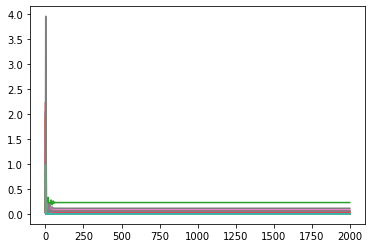

pruned node 0 with biomass 1.1514019708005594e-79
pruned node 4 with biomass 2.5e-323
pruned node 5 with biomass 2.5e-323
pruned node 8 with biomass 1.190097477094983e-251
pruned node 9 with biomass 1.5869822964304387e-79
pruned node 13 with biomass 2.5e-323
pruned node 14 with biomass 3.838126523502484e-266
pruned node 18 with biomass 8.71877237038316e-172
pruned node 20 with biomass 2.5e-323
pruned node 21 with biomass 2.5e-323
pruned node 22 with biomass 1.9278091319489688e-174
pruned node 24 with biomass 3e-323
pruned node 25 with biomass 1e-323
pruned node 28 with biomass 7.711576379967438e-252
pruned node 29 with biomass 2.5e-323
./paper_webs_0624/web_59 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_59 1164.294204235077
overall:


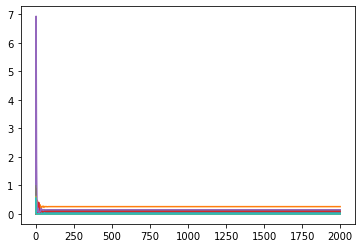

pruned node 3 with biomass 5.134292594066109e-27
pruned node 5 with biomass 3e-323
pruned node 6 with biomass 1e-323
pruned node 7 with biomass 1.2767763530846667e-237
pruned node 11 with biomass 1.9378578225667842e-114
pruned node 12 with biomass 7.954398310956549e-27
pruned node 13 with biomass 4.167995309921363e-26
pruned node 14 with biomass 3.5e-323
pruned node 16 with biomass 1.204445200024326e-163
pruned node 20 with biomass 3e-323
pruned node 22 with biomass 2.0603403616393844e-114
pruned node 25 with biomass 3e-323
pruned node 26 with biomass 1.6449700553837365e-239
pruned node 27 with biomass 1e-323
pruned node 29 with biomass 7.815809809040834e-26
./paper_webs_0624/web_39 final nodes: 15
final number of species after 2000 timesteps: 15
time for ./paper_webs_0624/web_39 1166.5106751918793


In [11]:
# SI Figure 11
p = Pool(multiprocessing.cpu_count()-2)
p.map(ATN.run_dynamics, webs0)
p.close()
p.join() #wait   